In [2]:
import sys,os,os.path
sys.path.append("../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize




def threshold_hits(threshold_charge, same_peak, hitc):
    """
    Applies a threshold to hits and redistributes the charge/energy.

    Parameters
    ----------
    threshold_charge : float
        minimum pes of a hit
    same_peak        : bool
        whether to reassign NN hits' energy only to the hits from the same peak

    Returns
    ----------
    A function that takes HitCollection as input and returns another object with
    only non NN hits of charge above threshold_charge.
    The energy of NN hits is redistributed among neighbors.
    """

    t = hitc.time
    thr_hits = hif.threshold_hits(hitc.hits, threshold_charge     )
    mrg_hits = hif.merge_NN_hits ( thr_hits, same_peak = same_peak)

    cor_hits = []
    for hit in mrg_hits:
        cluster = Cluster(hit.Q, xy(hit.X, hit.Y), hit.var, hit.nsipm)
        xypos   = xy(hit.Xpeak, hit.Ypeak)
        hit     = Hit(hit.npeak, cluster, hit.Z, hit.E, xypos, hit.Ec)
        cor_hits.append(hit)

    new_hitc      = HitCollection(hitc.event, t)
    new_hitc.hits = cor_hits
    return new_hitc





def hits_from_df (dst, skip_NN = False):
    """
    Function that transforms pandas DataFrame dst to HitCollection
    ------
    Parameters
    ------
    dst : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
        If time, nsipm, Xrms, Yrms, Qc, Ec, track_id are not
        inside dst the default value is set to -1
        If Xpeak, Ypeak not in dst the default value is -1000
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    https://github.com/next-exp/IC/blob/v2-development/invisible_cities/io/hits_io.py#L16
    """
    all_events = {}
    times = getattr(dst, 'time', [-1]*len(dst))
    for (event, time) , df in dst.groupby(['event', times]):
        #pandas is not consistent with numpy dtypes so we have to change it by hand
        event = np.int32(event)
        hits  = []
        for i, row in df.iterrows():
            Q = getattr(row,'Q', row.E)
            if skip_NN and Q == NN:
                continue
            if hasattr(row, 'Xrms'):
                Xrms  = row.Xrms
                Xrms2 = Xrms**2
            else:
                Xrms = Xrms2 = -1
            if hasattr(row, 'Yrms'):
                Yrms  = row.Yrms
                Yrms2 = Yrms**2
            else:
                Yrms = Yrms2 = -1
            nsipm   = getattr(row, 'nsipm'   , -1   )     # for backwards compatibility
            Qc      = getattr(row, 'Qc'      , -1   )     # for backwards compatibility
            Xpeak   = getattr(row, 'Xpeak'   , -1000)     # for backwards compatibility
            Ypeak   = getattr(row, 'Ypeak'   , -1000)     # for backwards compatibility
            Ec      = getattr(row, 'Ec'      , -1   )     # for backwards compatibility
            trackID = getattr(row, 'track_id', -1   )     # for backwards compatibility
            Ep      = getattr(row, "Ep"      , -1   )     # for backwards compatibility

            hit = Hit(row.npeak            ,
                      Cluster(Q               ,
                              xy(row.X, row.Y),
                              xy(Xrms2, Yrms2),
                              nsipm = nsipm   ,
                              z     = row.Z   ,
                              E     = row.E   ,
                              Qc    = Qc      ),
                      row.Z                ,
                      row.E                ,
                      xy(Xpeak, Ypeak)     ,
                      s2_energy_c = Ec     ,
                      track_id    = trackID,
                      Ep          = Ep     )

            hits.append(hit)

        if len(hits):
            all_events[event] = HitCollection(event, time, hits=hits)

    return all_events

def hitc_to_df_(hitc):
    columns = defaultdict(list)
    for hit in hitc.hits:
        columns["event"   ].append(hitc.event)
        columns["time"    ].append(hitc.time)
        columns["npeak"   ].append(hit .npeak)
        columns["Xpeak"   ].append(hit .Xpeak)
        columns["Ypeak"   ].append(hit .Ypeak)
        columns["nsipm"   ].append(hit .nsipm)
        columns["X"       ].append(hit .X)
        columns["Y"       ].append(hit .Y)
        columns["Xrms"    ].append(hit .Xrms)
        columns["Yrms"    ].append(hit .Yrms)
        columns["Z"       ].append(hit .Z)
        columns["Q"       ].append(hit .Q)
        columns["E"       ].append(hit .E)
        columns["Qc"      ].append(hit .Qc)
        columns["Ec"      ].append(hit .Ec)
        columns["track_id"].append(hit .track_id)
        columns["Ep"      ].append(hit .Ep)
    return pd.DataFrame(columns)






def soph_to_lowTh(df, threshold = 5):
    '''
    Converts sophronia 'RECO/Events' to lowTh events via a rather convoluted process
    Made by me (John Waiton), so dont treat it like a normal function from IC!
    ------
    Parameters
    ------
    df : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
    threshold: int
        value at which the threshold is set.
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    '''

    # safety check, to ensure you don't accidentally make a repeating dataframe
    


    # new parameters for threshold, this is silly but I'm copying previous convention
    pes = 1
    threshold = threshold * pes
    same_peak = True

    # convert sophronia RECO/Events to hit collection
    soph_hitc = hits_from_df(df)

    # collect the keys as the event numbers
    soph_hitc_list = list(soph_hitc.keys())

    print("Processing data...")
    # loop over all of these events
    j = 0
    for i in soph_hitc_list:
        j += 1

        if (len(soph_hitc_list)%j == 50): 
            print("{}/{}".format(j, len(soph_hitc_list)))
        # choose i'th event
        soph_hit_event = soph_hitc.get(i)

        # Apply threshold calculation
        soph_hitc_lowTh = threshold_hits(threshold, same_peak, soph_hit_event)

        # convert back to pandas dataframe using hitc_to_df
        soph_hdst_lowTh = hitc_to_df_(soph_hitc_lowTh)

        # check if pandas dataframe with all the events exists yet
        if 'full_soph_df' in locals() and isinstance(full_soph_df, pd.DataFrame):
            full_soph_df = pd.concat([full_soph_df, soph_hdst_lowTh])
        else:
            full_soph_df = soph_hdst_lowTh.copy(deep = True)
    
    return full_soph_df




# files here

In [4]:
soph_file = f'/home/e78368jw/Documents/NEXT_CODE/next_misc/energy_topology_study/testing_data/sophronia_27_208Tl.h5'
soph_hdst = dstio.load_dst(soph_file, 'RECO', 'Events')#CHITS/lowTh

true_info = mcio.load_mchits_df(soph_file).reset_index()

In [9]:
# event number of interest here
event_id = 520470

In [ ]:
# lets look at the list of signal events and lost signal events
MC_signals = np.load('port_1a_signal_evts.npy')
lost_signals = np.load('port_1a_isaura_lost_evts.npy')/2

print(event_id in lost_signals)

In [13]:
event_soph = soph_hdst[soph_hdst.event == event_id]
mc_soph = true_info[true_info.event_id == event_id/2]
display(event_soph)
display(mc_soph)


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
109788,520470,5.204706e+11,0,-15.628242,3.905621,1,-7.775,69.975,0.0,0.0,877.749994,4.173913,339.000000,-1.0,0.001091,-1,-1.0
109789,520470,5.204706e+11,0,-15.628242,3.905621,1,7.775,69.975,0.0,0.0,877.749994,4.173913,339.000000,-1.0,0.001090,-1,-1.0
109790,520470,5.204706e+11,0,-15.628242,3.905621,1,-7.775,69.975,0.0,0.0,880.797553,5.507246,444.063383,-1.0,0.001430,-1,-1.0
109791,520470,5.204706e+11,0,-15.628242,3.905621,1,7.775,54.425,0.0,0.0,880.797553,9.797101,789.965403,-1.0,0.002535,-1,-1.0
109792,520470,5.204706e+11,0,-15.628242,3.905621,1,7.775,69.975,0.0,0.0,880.797553,4.753623,383.296825,-1.0,0.001233,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110679,520470,5.204706e+11,0,-15.628242,3.905621,1,7.775,-23.325,0.0,0.0,974.553628,6.956522,378.855599,-1.0,0.001231,-1,-1.0
110680,520470,5.204706e+11,0,-15.628242,3.905621,1,7.775,-7.775,0.0,0.0,974.553628,5.391304,293.613087,-1.0,0.000957,-1,-1.0
110681,520470,5.204706e+11,0,-15.628242,3.905621,1,7.775,7.775,0.0,0.0,974.553628,6.492754,353.598540,-1.0,0.001153,-1,-1.0
110682,520470,5.204706e+11,0,-15.628242,3.905621,1,-85.525,-101.075,0.0,0.0,977.768400,4.347826,532.361973,-1.0,0.001743,-1,-1.0


,event_id,particle_id,hit_id,x,y,z,time,energy,label
87645,260235,33,0,1.903661,63.397884,887.703247,2.249825,0.000021,ACTIVE
87646,260235,32,0,2.495320,62.597496,887.799744,2.086922,0.002596,ACTIVE
87647,260235,32,1,3.055303,61.781494,887.830383,2.090396,0.002120,ACTIVE
87648,260235,32,2,3.585819,60.945576,887.819763,2.093871,0.000996,ACTIVE
87649,260235,32,3,4.041701,60.066914,887.799133,2.097346,0.001261,ACTIVE
...,...,...,...,...,...,...,...,...,...
88330,260235,85,9,-0.340700,59.624142,890.745789,2.111066,0.000794,ACTIVE
88331,260235,85,10,-0.347312,59.618935,890.743591,2.111278,0.000862,ACTIVE
88332,260235,85,11,-0.342924,59.623440,890.741516,2.111454,0.001830,ACTIVE
88333,260235,85,12,-0.343436,59.624454,890.744141,2.111558,0.002050,ACTIVE


690
896


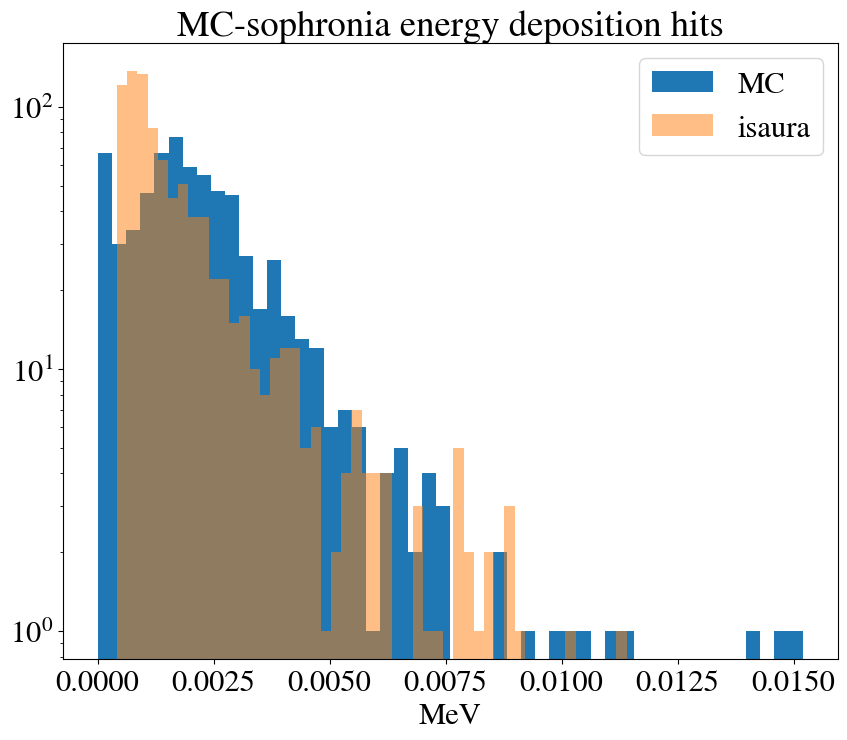

In [19]:
print(len(mc_soph.energy.values))
print(len(event_soph.Ec.values))

log_check= True
# plot energy of hits as histograms.
plt.hist(mc_soph.energy.values, bins = 50, log = log_check, label = 'MC')
plt.hist(event_soph.Ec.values, bins = 50, log = log_check, alpha = 0.5, label = 'isaura')
plt.title("{}".format('MC-sophronia energy deposition hits'))
plt.legend()
plt.xlabel('MeV')
plt.show()